In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('float_format', '{:.2f}'.format)
import warnings
import re
warnings.filterwarnings('ignore')
import string
from wordcloud import WordCloud, STOPWORDS


In [2]:
trend_videos = pd.read_csv('archive/US_youtube_trending_data.csv')

In [3]:
trend_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56391 entries, 0 to 56390
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           56391 non-null  object
 1   title              56391 non-null  object
 2   publishedAt        56391 non-null  object
 3   channelId          56391 non-null  object
 4   channelTitle       56391 non-null  object
 5   categoryId         56391 non-null  int64 
 6   trending_date      56391 non-null  object
 7   tags               56391 non-null  object
 8   view_count         56391 non-null  int64 
 9   likes              56391 non-null  int64 
 10  dislikes           56391 non-null  int64 
 11  comment_count      56391 non-null  int64 
 12  thumbnail_link     56391 non-null  object
 13  comments_disabled  56391 non-null  bool  
 14  ratings_disabled   56391 non-null  bool  
 15  description        55900 non-null  object
dtypes: bool(2), int64(5), object(9)
memory u

In [4]:
trend_videos.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


In [5]:
trend_videos["description"] = trend_videos["description"].fillna(value="Video has no description")

In [6]:
cols = ['tags', 'view_count']
vids = trend_videos[cols]

In [7]:
tags_with_viewcount_list = list(vids.itertuples(index=False, name=None))

In [8]:
tag_data = {}

def buildTagsArray(tagDict):
    tags = []
    for x in tagDict:
        tags.append(x)
    return tags


def findMean(tagDict):
    averages = []
    for x in tagDict:
        averages.append(sum(tagDict[x])//len(tagDict[x]))
    return averages

def findMedian(tagDict):
    medians = []
    for x in tagDict:
        tagDict[x].sort()
        mid = len(tagDict[x]) // 2
        res = (tagDict[x][mid] + tagDict[x][~mid]) // 2
        medians.append(res)
    return medians

def findTotals(tagDict):
    totals = []
    for x in tagDict:
        totals.append(sum(tagDict[x]))
    return totals

def frequency_used(tagDict):
    count = []
    for x in tagDict:
        count.append(len(tagDict[x]))
    return count

for tags in tags_with_viewcount_list:
    for tag in tags[0].split('|'):

        if tag not in tag_data:
            tag_data[tag] = [tags[1]]
        else:
            tag_data[tag].append(tags[1])


data = {'tag': buildTagsArray(tag_data),
        'frequency_used': frequency_used(tag_data),
        'total_view_count': findTotals(tag_data),
        'mean_view_count': findMean(tag_data),
        'median_view_count': findMedian(tag_data)
        }


new_df = pd.DataFrame(data, columns =['tag', 'frequency_used', 'total_view_count', 'mean_view_count', 'median_view_count'])

          tag  total_view_count
132    [None]       27124820915
41      funny        8171812125
3707      BTS        6892916601
3706    방탄소년단        6081735493
3708  BANGTAN        5780723481
215    comedy        4890526708
5920      빅히트        4757462969
5921       방탄        4643022973
5919   BIGHIT        4633183436
7634     블랙핑크        4193548571


[Text(0.5, 1.0, 'Total View Count By Tag')]

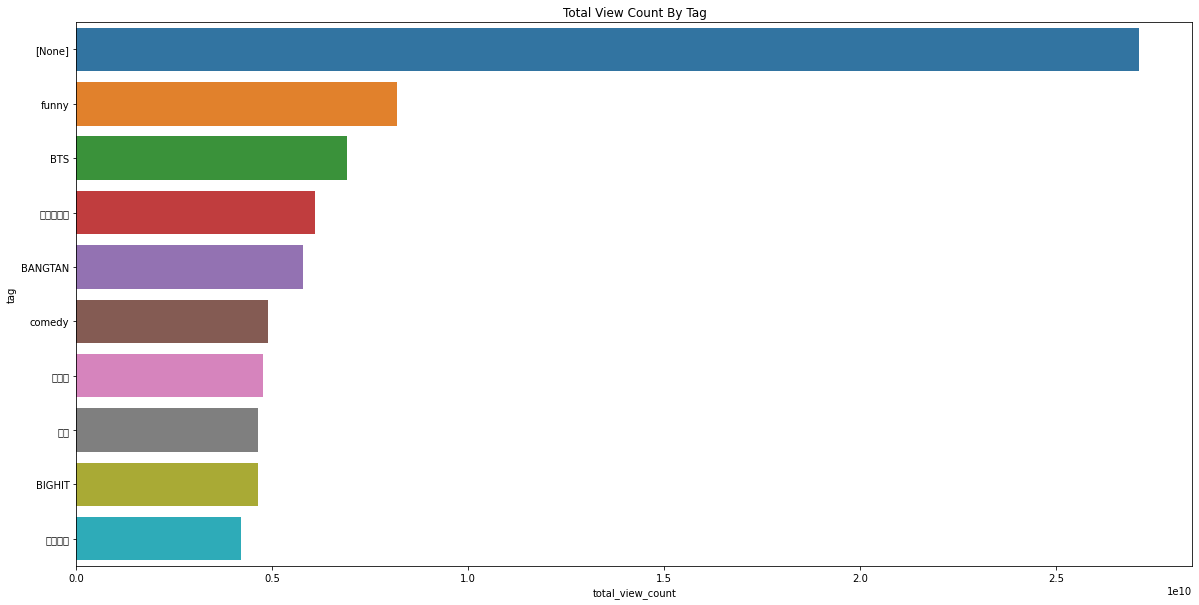

In [9]:
select_cols = ['tag', 'total_view_count']
x = new_df[select_cols].sort_values(by=['total_view_count'], ascending=False).head(10)
print(x)
plt.figure(figsize=(20,10))
sns.barplot(data=x, x='total_view_count', y='tag').set(title='Total View Count By Tag')

[Text(0.5, 1.0, 'Frequency of Tag Use')]

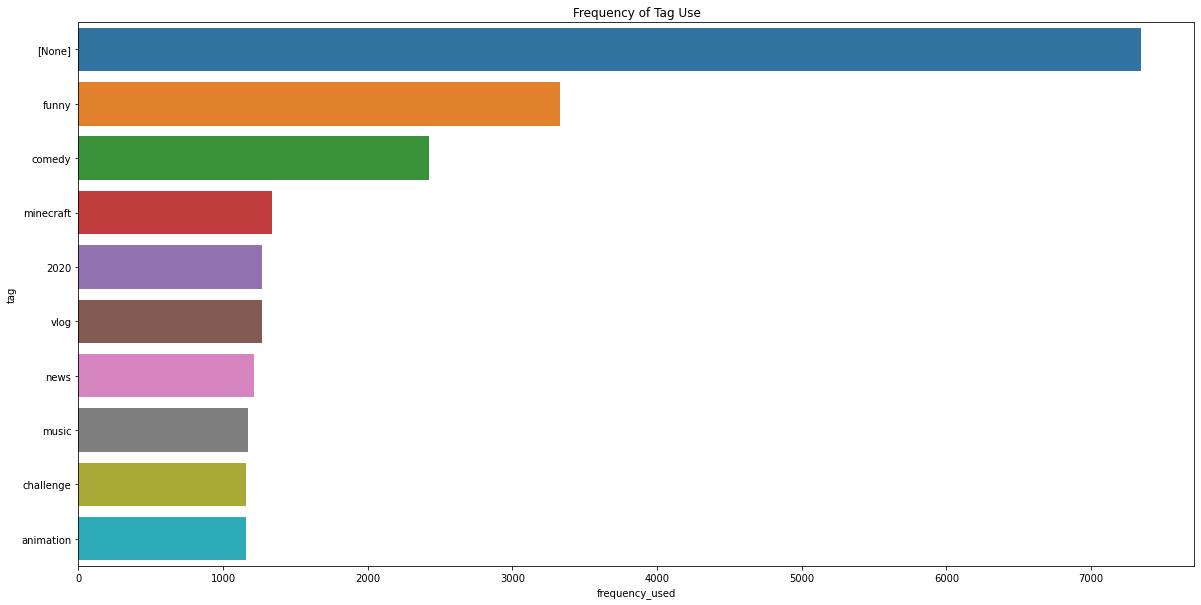

In [10]:
select_cols = ['tag', 'frequency_used']
x = new_df[select_cols].sort_values(by=['frequency_used'], ascending=False).head(10)
plt.figure(figsize=(20,10))
sns.barplot(data=x, x='frequency_used', y='tag').set(title='Frequency of Tag Use')

                          tag  mean_view_count
983               lEIqjoO0-Bs         88037385
982               cJc7xWJbwJw         88037385
9314                  Selpink         70684780
7650        셀레나 고메즈 Ice Cream         58604173
7647      BLACKPINK Ice Cream         58604173
7648           블랙핑크 Ice Cream         58604173
7649   Selena Gomez Ice Cream         58604173
9315                      셀핑크         56735660
74746            DIY projects         51899368
74744  5-Minute Crafts Family         51899368


[Text(0.5, 1.0, 'Mean View Count By Tag')]

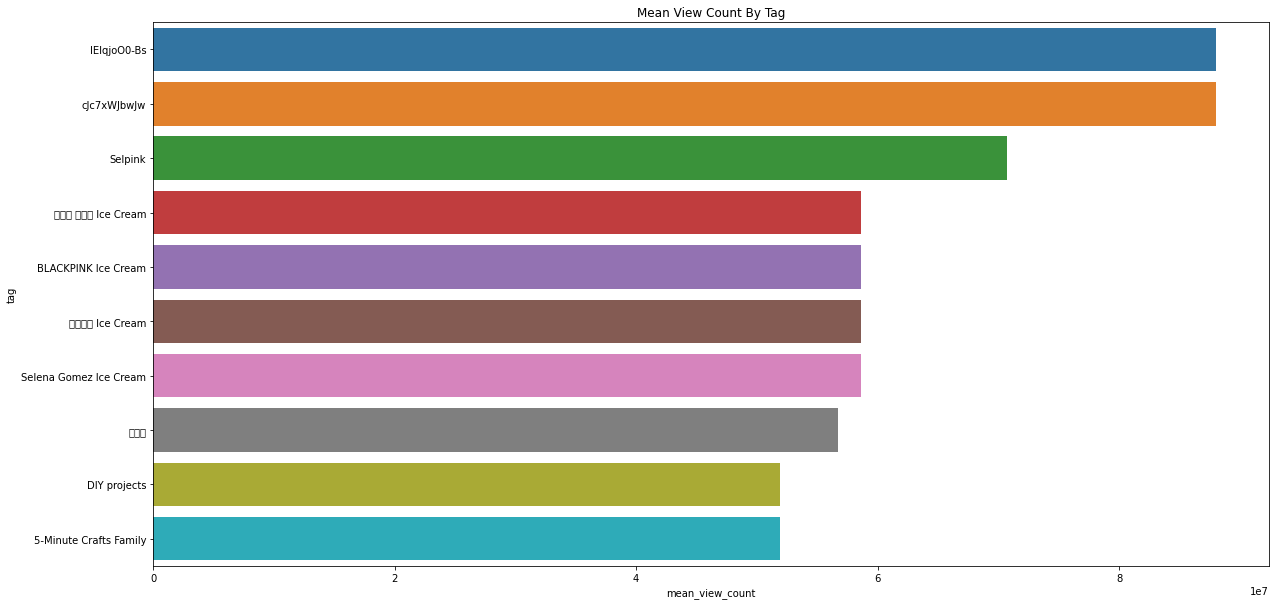

In [11]:
select_cols = ['tag', 'mean_view_count']
x = new_df[select_cols].sort_values(by=['mean_view_count'], ascending=False).head(10)
print(x)
plt.figure(figsize=(20,10))
sns.barplot(data=x, x='mean_view_count', y='tag').set(title='Mean View Count By Tag')

                                    tag  median_view_count
983                         lEIqjoO0-Bs           88240316
982                         cJc7xWJbwJw           88240316
32050           twice eyes wide open mv           57741769
32055                       아이즈와이드오픈 뮤비           57741769
32056                        아이캔트스탑미 뮤비           57741769
32053  twice music video I cant stop me           57741769
32052  twice I cant stop me music video           57741769
32054  twice music video eyes wide open           57741769
26387                         99 player           56929518
73520                              dina           54717565


[Text(0.5, 1.0, 'Medain View Count By Tag')]

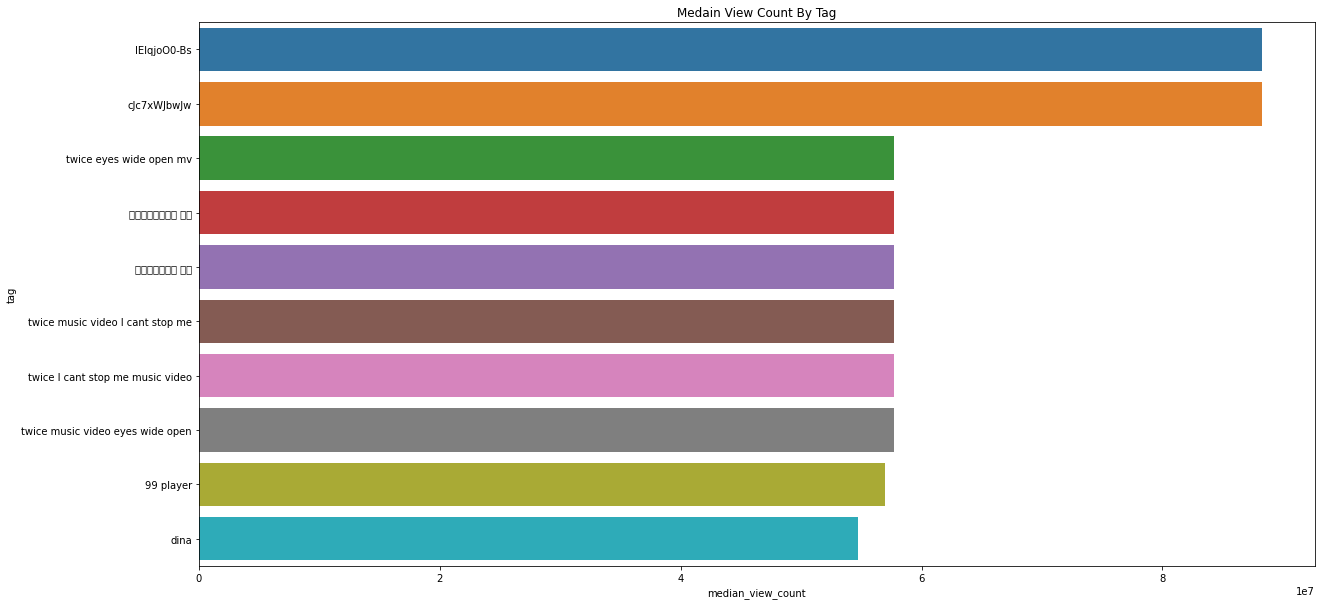

In [12]:
select_cols = ['tag', 'median_view_count']
x = new_df[select_cols].sort_values(by=['median_view_count'], ascending=False).head(10)
print(x)
plt.figure(figsize=(20,10))
sns.barplot(data=x, x='median_view_count', y='tag').set(title='Medain View Count By Tag')

(-0.5, 1999.5, 999.5, -0.5)

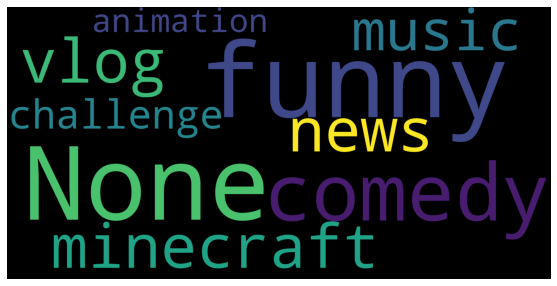

In [13]:
select_cols = ['tag', 'frequency_used']

tagData = new_df[select_cols].sort_values(by=['frequency_used'], ascending=False).head(10)

tags_and_frequency = list(tagData.itertuples(index=False, name=None))

tags_only = []

for t in tags_and_frequency:
    tags_only.append(re.sub('[^a-zA-Z]', ' ', t[0]))
 
wordcld = WordCloud(width= 2000, height= 1000, stopwords= set(STOPWORDS)).generate(' '.join(tags_only))
plt.figure(figsize=(15,5))
plt.imshow(wordcld)
plt.axis('off')
